In [20]:
import os
import platform
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [21]:
os.getcwd()

'/Users/youngseoklee/Desktop/workplace/dacon_energy'

In [22]:
#파일경로 설정
if 'macOS' in platform.platform():
    path = '/Users/youngseoklee/Desktop/workplace/datas/dacon_energy/'
    print(path)
elif 'Linux' in platform.platform():
    path = '/workplace/datas/dacon_energy/'
    print(path)
else:
    print('어느 os에도 속해있지 않습니다')

/Users/youngseoklee/Desktop/workplace/datas/dacon_energy/


In [23]:
train_df = pd.read_csv(path + 'train_df.csv', index_col=0)
test_df = pd.read_csv(path + 'test_df.csv', index_col=0)

sub = pd.read_csv(path + 'sample_submission.csv', index_col=0)

In [24]:
train_df.shape , test_df.shape

((204000, 27), (16800, 26))

In [25]:
train_df.keys()

Index(['건물번호', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '전력소비량(kWh)', 'Year',
       'Month', 'Day', 'Hour', '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)',
       'ESS저장용량(kWh)', 'PCS용량(kW)', '건물유형_건물기타', '건물유형_공공', '건물유형_대학교',
       '건물유형_데이터센터', '건물유형_백화점및아울렛', '건물유형_병원', '건물유형_상용', '건물유형_아파트',
       '건물유형_연구소', '건물유형_지식산업센터', '건물유형_할인마트', '건물유형_호텔및리조트'],
      dtype='object')

In [26]:
SEQUENCE_LENGTH = 24
TRAIN_SIZE = 0.9

# Select all columns and convert to numpy array
X = train_df.drop('전력소비량(kWh)', axis=1).values
y = train_df['전력소비량(kWh)'].values



# Generate sequences
#X = [X[i:i+SEQUENCE_LENGTH, :] for i in range(X.shape[0]-SEQUENCE_LENGTH)]
#y = [y[i+SEQUENCE_LENGTH] for i in range(y.shape[0]-SEQUENCE_LENGTH)]
X, y = np.array(X), np.array(y).reshape(-1, 1)


In [27]:
# Split into training and validation datasets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=TRAIN_SIZE, shuffle=False)

In [28]:
X_train.shape, y_train.shape

((183600, 26), (183600, 1))

# Modeling

In [29]:
import optuna
import lightgbm as lgb
import xgboost as xgb
from torchmetrics.regression import MeanAbsolutePercentageError
from sklearn.metrics import mean_absolute_percentage_error

In [30]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label = y_val)
dtest = xgb.DMatrix(test_df)

In [ ]:
'''
파라미터들의 정보를 알기 위해서는 어떻게 해야할까??

DMatrix로 묶고 train에 넣었을 때 왜 안되는 걸까?
'''

In [44]:
xgb.get_config()

{'use_rmm': False, 'verbosity': 2}

In [54]:
def objective(trial):
    params = {
        'booster':'dart',
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'eta': trial.suggest_loguniform('eta', 0.01, 1.0),
        'lambda':trial.suggest_loguniform('lambda', 0.1, 1.0),
        'alpha':trial.suggest_loguniform('alpha', 0.1, 1.0) ,
        'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        
    }

    bst = xgb.train(params, dtrain, evals=[(dval, 'validation')],early_stopping_rounds=100, num_boost_round=100)
    preds = bst.predict(xgb.DMatrix(X_val))
    mape = mean_absolute_percentage_error(y_val, preds)
    print("MAPE: {}".format(mape))
    return mape

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print(study.best_trial)
print(study.best_value)
# Print best parameters
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-08-09 15:23:26,760] A new study created in memory with name: no-name-7db26a48-871f-4d9f-a58e-dfa904a93c63


[15:23:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 142 extra nodes, 0 pruned nodes, max_depth=9
[15:23:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[0]	validation-rmse:1452.16493
[15:23:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=9
[15:23:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[1]	validation-rmse:1355.67218
[15:23:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, ma

/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'eta': trial.suggest_loguniform('eta', 0.01, 1.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda':trial.suggest_loguniform('lambda', 0.1, 1.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float`

[15:23:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 188 extra nodes, 0 pruned nodes, max_depth=9
[15:23:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[6]	validation-rmse:881.49624
[15:23:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 382 extra nodes, 0 pruned nodes, max_depth=9
[15:23:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[7]	validation-rmse:829.52182
[15:23:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max

[15:23:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=9
[15:23:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[27]	validation-rmse:471.38226
[15:23:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 592 extra nodes, 0 pruned nodes, max_depth=9
[15:23:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[28]	validation-rmse:470.71493
[15:23:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, ma

[15:23:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 524 extra nodes, 0 pruned nodes, max_depth=9
[15:23:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[48]	validation-rmse:349.35946
[15:23:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 628 extra nodes, 0 pruned nodes, max_depth=9
[15:23:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[49]	validation-rmse:345.71302
[15:23:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 264 extra nodes, 0 pruned nodes, 

[15:23:35] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=8
[15:23:35] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[69]	validation-rmse:306.16251
[15:23:35] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[15:23:35] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[70]	validation-rmse:306.21640
[15:23:35] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max

[15:23:40] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 496 extra nodes, 0 pruned nodes, max_depth=9
[15:23:40] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[90]	validation-rmse:277.51911
[15:23:40] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 852 extra nodes, 0 pruned nodes, max_depth=9
[15:23:40] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[91]	validation-rmse:274.74264
[15:23:41] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 902 extra nodes, 0 pruned nodes, 

[I 2023-08-09 15:23:43,040] Trial 0 finished with value: 401684744668293.0 and parameters: {'max_depth': 9, 'eta': 0.09403326354005702, 'lambda': 0.5143385631150312, 'alpha': 0.21645328300688052, 'gamma': 0.9786883548350223, 'subsample': 0.6496537917335221, 'colsample_bytree': 0.1655912272934436}. Best is trial 0 with value: 401684744668293.0.


MAPE: 401684744668293.0
[15:23:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 216 extra nodes, 0 pruned nodes, max_depth=9
[15:23:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[0]	validation-rmse:1605.28170
[15:23:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=9
[15:23:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[1]	validation-rmse:1568.08628
[15:23:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 114 extra 

/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'eta': trial.suggest_loguniform('eta', 0.01, 1.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda':trial.suggest_loguniform('lambda', 0.1, 1.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float`

[15:23:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 216 extra nodes, 0 pruned nodes, max_depth=9
[15:23:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[6]	validation-rmse:1364.30422
[15:23:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=9
[15:23:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[7]	validation-rmse:1330.53985
[15:23:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, 

[15:23:44] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 132 extra nodes, 0 pruned nodes, max_depth=9
[15:23:44] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[27]	validation-rmse:813.48336
[15:23:44] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 640 extra nodes, 0 pruned nodes, max_depth=9
[15:23:44] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[28]	validation-rmse:794.19159
[15:23:44] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, 

[15:23:47] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 544 extra nodes, 0 pruned nodes, max_depth=9
[15:23:47] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[48]	validation-rmse:572.78353
[15:23:47] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 742 extra nodes, 0 pruned nodes, max_depth=9
[15:23:47] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[49]	validation-rmse:566.77230
[15:23:47] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 498 extra nodes, 0 pruned nodes, 

[68]	validation-rmse:459.74305
[15:23:51] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=9
[15:23:51] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[69]	validation-rmse:457.45139
[15:23:51] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[15:23:51] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[70]	validation-rmse:456.17162
[15:23:51] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 116

[15:23:56] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 542 extra nodes, 0 pruned nodes, max_depth=9
[15:23:56] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[90]	validation-rmse:399.96200
[15:23:56] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 640 extra nodes, 0 pruned nodes, max_depth=9
[15:23:56] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[91]	validation-rmse:395.92421
[15:23:56] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 722 extra nodes, 0 pruned nodes, 

[I 2023-08-09 15:23:58,691] Trial 1 finished with value: 388192254810689.1 and parameters: {'max_depth': 9, 'eta': 0.029695049417835462, 'lambda': 0.866237783247636, 'alpha': 0.44169151104816945, 'gamma': 0.21762825318080195, 'subsample': 0.12218974000315524, 'colsample_bytree': 0.2576748326967014}. Best is trial 1 with value: 388192254810689.1.


MAPE: 388192254810689.1
[15:23:58] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 854 extra nodes, 0 pruned nodes, max_depth=10
[15:23:58] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[0]	validation-rmse:1609.29883
[15:23:58] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 582 extra nodes, 0 pruned nodes, max_depth=10
[15:23:58] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[1]	validation-rmse:1568.22454
[15:23:58] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 780 ext

/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'eta': trial.suggest_loguniform('eta', 0.01, 1.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda':trial.suggest_loguniform('lambda', 0.1, 1.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float`

[2]	validation-rmse:1527.64622
[15:23:58] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 860 extra nodes, 0 pruned nodes, max_depth=10
[15:23:58] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[3]	validation-rmse:1487.92643
[15:23:59] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 1094 extra nodes, 0 pruned nodes, max_depth=10
[15:23:59] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[4]	validation-rmse:1451.67348
[15:23:59] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end,

[15:24:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 1028 extra nodes, 0 pruned nodes, max_depth=10
[15:24:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[24]	validation-rmse:890.32097
[15:24:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 1168 extra nodes, 0 pruned nodes, max_depth=10
[15:24:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[25]	validation-rmse:869.52031
[15:24:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 1078 extra nodes, 0 pruned no

[44]	validation-rmse:582.38477
[15:24:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 1218 extra nodes, 0 pruned nodes, max_depth=10
[15:24:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[45]	validation-rmse:572.06621
[15:24:05] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 1434 extra nodes, 0 pruned nodes, max_depth=10
[15:24:05] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[46]	validation-rmse:562.69006
[15:24:05] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end

[15:24:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 1632 extra nodes, 0 pruned nodes, max_depth=10
[15:24:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[66]	validation-rmse:399.99160
[15:24:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 1270 extra nodes, 0 pruned nodes, max_depth=10
[15:24:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[67]	validation-rmse:396.06605
[15:24:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 1256 extra nodes, 0 pruned no

[15:24:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 1340 extra nodes, 0 pruned nodes, max_depth=10
[15:24:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[87]	validation-rmse:304.92635
[15:24:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 1342 extra nodes, 0 pruned nodes, max_depth=10
[15:24:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[88]	validation-rmse:302.17004
[15:24:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 1358 extra nodes, 0 pruned no

[I 2023-08-09 15:24:20,681] Trial 2 finished with value: 346024097468470.9 and parameters: {'max_depth': 10, 'eta': 0.028375262920727246, 'lambda': 0.2166024516864579, 'alpha': 0.19633822938459358, 'gamma': 0.08003149632038392, 'subsample': 0.6088326435230323, 'colsample_bytree': 0.7936448999322572}. Best is trial 2 with value: 346024097468470.9.


MAPE: 346024097468470.9
[15:24:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:24:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[0]	validation-rmse:1529.43380
[15:24:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:24:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[1]	validation-rmse:1431.62536
[15:24:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 14 extra no

/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'eta': trial.suggest_loguniform('eta', 0.01, 1.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda':trial.suggest_loguniform('lambda', 0.1, 1.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float`

[15:24:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:24:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[7]	validation-rmse:967.02915
[15:24:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:24:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[8]	validation-rmse:922.83884
[15:24:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_d

[15:24:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:24:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[28]	validation-rmse:654.20141
[15:24:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:24:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[29]	validation-rmse:653.79488
[15:24:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max

[15:24:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:24:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[49]	validation-rmse:623.75076
[15:24:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:24:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[50]	validation-rmse:624.85087
[15:24:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max

[15:24:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:24:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[70]	validation-rmse:572.45041
[15:24:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:24:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[71]	validation-rmse:571.12444
[15:24:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max

[15:24:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:24:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[91]	validation-rmse:544.24861
[15:24:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:24:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[92]	validation-rmse:540.05981
[15:24:32] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max

[I 2023-08-09 15:24:33,509] Trial 3 finished with value: 496806945035438.9 and parameters: {'max_depth': 3, 'eta': 0.06990590283333332, 'lambda': 0.28211345260375115, 'alpha': 0.31475229057790105, 'gamma': 0.36818311159691075, 'subsample': 0.32816368953944997, 'colsample_bytree': 0.6802018530498445}. Best is trial 2 with value: 346024097468470.9.


MAPE: 496806945035438.9
[15:24:33] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 190 extra nodes, 0 pruned nodes, max_depth=8
[15:24:33] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[0]	validation-rmse:740.35685
[15:24:33] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=8
[15:24:33] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[1]	validation-rmse:632.84428
[15:24:33] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 extra no

/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'eta': trial.suggest_loguniform('eta', 0.01, 1.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda':trial.suggest_loguniform('lambda', 0.1, 1.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float`

[15:24:33] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=8
[15:24:33] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[6]	validation-rmse:346.30827
[15:24:33] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 362 extra nodes, 0 pruned nodes, max_depth=8
[15:24:33] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[7]	validation-rmse:328.07684
[15:24:33] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max

[15:24:35] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=8
[15:24:35] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[27]	validation-rmse:196.44439
[15:24:35] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 356 extra nodes, 0 pruned nodes, max_depth=8
[15:24:35] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[28]	validation-rmse:196.54102
[15:24:35] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 154 extra nodes, 0 pruned nodes, 

[15:24:37] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=8
[15:24:37] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[48]	validation-rmse:182.24904
[15:24:37] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 442 extra nodes, 0 pruned nodes, max_depth=8
[15:24:37] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[49]	validation-rmse:182.86739
[15:24:38] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 370 extra nodes, 0 pruned nodes, 

[68]	validation-rmse:194.91559
[15:24:41] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=8
[15:24:41] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[69]	validation-rmse:194.91305
[15:24:41] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=5
[15:24:41] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[70]	validation-rmse:194.91547
[15:24:41] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 90 e

[15:24:46] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 318 extra nodes, 0 pruned nodes, max_depth=8
[15:24:46] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[90]	validation-rmse:188.86791
[15:24:46] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 450 extra nodes, 0 pruned nodes, max_depth=8
[15:24:46] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[91]	validation-rmse:188.77790
[15:24:46] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 486 extra nodes, 0 pruned nodes, 

[I 2023-08-09 15:24:48,913] Trial 4 finished with value: 311022357494870.2 and parameters: {'max_depth': 8, 'eta': 0.6899483235544007, 'lambda': 0.6575800041578816, 'alpha': 0.8628873055144217, 'gamma': 0.5686169027650068, 'subsample': 0.8152575285029862, 'colsample_bytree': 0.21766458645071274}. Best is trial 4 with value: 311022357494870.2.


MAPE: 311022357494870.2
[15:24:48] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[15:24:48] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[0]	validation-rmse:1479.15908
[15:24:48] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[15:24:48] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[1]	validation-rmse:1335.42326
[15:24:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 118 extra

/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'eta': trial.suggest_loguniform('eta', 0.01, 1.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda':trial.suggest_loguniform('lambda', 0.1, 1.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float`

[15:24:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[15:24:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[5]	validation-rmse:904.91974
[15:24:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[15:24:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[6]	validation-rmse:810.38909
[15:24:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, ma

[15:24:50] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[15:24:50] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[26]	validation-rmse:475.47588
[15:24:50] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[15:24:50] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[27]	validation-rmse:475.65364
[15:24:50] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, 

[15:24:53] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[15:24:53] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[47]	validation-rmse:339.98046
[15:24:53] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[15:24:53] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[48]	validation-rmse:315.32622
[15:24:53] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, 

[67]	validation-rmse:278.91498
[15:24:56] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[15:24:56] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[68]	validation-rmse:278.91319
[15:24:57] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[15:24:57] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[69]	validation-rmse:279.03859
[15:24:57] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 12

[15:25:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[15:25:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[89]	validation-rmse:225.39546
[15:25:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[15:25:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[90]	validation-rmse:225.78592
[15:25:02] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, 

[I 2023-08-09 15:25:04,367] Trial 5 finished with value: 366268073799278.7 and parameters: {'max_depth': 6, 'eta': 0.11915126493307303, 'lambda': 0.2057729147158672, 'alpha': 0.4050573838241539, 'gamma': 0.8570123437374167, 'subsample': 0.6681665952902922, 'colsample_bytree': 0.687830180172651}. Best is trial 4 with value: 311022357494870.2.


MAPE: 366268073799278.7
[15:25:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[15:25:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[0]	validation-rmse:1237.48892
[15:25:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=4
[15:25:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[1]	validation-rmse:1020.07913
[15:25:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 16 extra no

/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'eta': trial.suggest_loguniform('eta', 0.01, 1.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda':trial.suggest_loguniform('lambda', 0.1, 1.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float`

[15:25:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[15:25:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[8]	validation-rmse:718.84180
[15:25:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[15:25:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[9]	validation-rmse:713.61683
[15:25:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_d

[15:25:05] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[15:25:05] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[29]	validation-rmse:482.31929
[15:25:05] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[15:25:05] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[30]	validation-rmse:481.99758
[15:25:05] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max

[15:25:07] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[15:25:07] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[50]	validation-rmse:318.01966
[15:25:08] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[15:25:08] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[51]	validation-rmse:318.31726
[15:25:08] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max

[70]	validation-rmse:303.33916
[15:25:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=4
[15:25:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[71]	validation-rmse:285.02525
[15:25:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[15:25:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[72]	validation-rmse:285.15822
[15:25:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 8 ext

[15:25:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[15:25:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[92]	validation-rmse:259.67806
[15:25:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[15:25:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[93]	validation-rmse:259.66795
[15:25:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_

[I 2023-08-09 15:25:17,241] Trial 6 finished with value: 436793417537457.7 and parameters: {'max_depth': 4, 'eta': 0.30662971837879205, 'lambda': 0.4148701990599098, 'alpha': 0.4880014323206282, 'gamma': 0.06688276895570842, 'subsample': 0.37331139224809495, 'colsample_bytree': 0.21922969702583117}. Best is trial 4 with value: 311022357494870.2.


MAPE: 436793417537457.7
[15:25:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=7
[15:25:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[0]	validation-rmse:793.93221
[15:25:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=7
[15:25:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[1]	validation-rmse:776.79222
[15:25:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 8 extra nod

/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'eta': trial.suggest_loguniform('eta', 0.01, 1.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda':trial.suggest_loguniform('lambda', 0.1, 1.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float`

[15:25:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=7
[15:25:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[7]	validation-rmse:582.23216
[15:25:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=4
[15:25:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[8]	validation-rmse:581.27061
[15:25:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 196 extra nodes, 0 pruned nodes, max_

[15:25:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 172 extra nodes, 0 pruned nodes, max_depth=7
[15:25:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[28]	validation-rmse:398.65796
[15:25:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[15:25:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[29]	validation-rmse:398.65168
[15:25:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 188 extra nodes, 0 pruned nodes, ma

[15:25:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=7
[15:25:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[49]	validation-rmse:304.50118
[15:25:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[15:25:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[50]	validation-rmse:304.44677
[15:25:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_

[15:25:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[15:25:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[70]	validation-rmse:275.83598
[15:25:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=7
[15:25:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[71]	validation-rmse:275.85641
[15:25:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_d

[15:25:29] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=7
[15:25:29] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[91]	validation-rmse:265.92087
[15:25:29] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 140 extra nodes, 0 pruned nodes, max_depth=7
[15:25:29] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[92]	validation-rmse:266.05961
[15:25:29] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, ma

[I 2023-08-09 15:25:31,463] Trial 7 finished with value: 400460594773887.9 and parameters: {'max_depth': 7, 'eta': 0.5362641521288419, 'lambda': 0.17081038360974432, 'alpha': 0.5573749339653369, 'gamma': 0.6364720997798595, 'subsample': 0.4381040644866466, 'colsample_bytree': 0.1192591719967639}. Best is trial 4 with value: 311022357494870.2.


MAPE: 400460594773887.9
[15:25:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:25:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[0]	validation-rmse:1428.76807
[15:25:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:25:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[1]	validation-rmse:1254.10879
[15:25:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes

/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'eta': trial.suggest_loguniform('eta', 0.01, 1.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda':trial.suggest_loguniform('lambda', 0.1, 1.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float`

[15:25:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:25:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[9]	validation-rmse:788.16081
[15:25:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:25:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[10]	validation-rmse:773.59449
[15:25:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_dep

[15:25:32] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:25:32] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[30]	validation-rmse:706.12359
[15:25:32] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:25:32] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[31]	validation-rmse:706.22658
[15:25:32] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_de

[15:25:34] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:25:34] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[51]	validation-rmse:651.38893
[15:25:35] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:25:35] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[52]	validation-rmse:651.62651
[15:25:35] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_de

[15:25:38] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:25:38] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[72]	validation-rmse:608.87183
[15:25:38] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:25:38] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[73]	validation-rmse:608.62145
[15:25:38] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_de

[15:25:42] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:25:42] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[93]	validation-rmse:554.60991
[15:25:42] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:25:42] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[94]	validation-rmse:554.42687
[15:25:42] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_de

[I 2023-08-09 15:25:43,613] Trial 8 finished with value: 502826070528337.94 and parameters: {'max_depth': 2, 'eta': 0.12780817897805738, 'lambda': 0.622874991276304, 'alpha': 0.295915643274387, 'gamma': 0.09259610691776402, 'subsample': 0.7609562162916685, 'colsample_bytree': 0.6954969771831246}. Best is trial 4 with value: 311022357494870.2.


MAPE: 502826070528337.94
[15:25:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:25:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[0]	validation-rmse:1171.19820
[15:25:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:25:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[1]	validation-rmse:929.83737
[15:25:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes

/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'eta': trial.suggest_loguniform('eta', 0.01, 1.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda':trial.suggest_loguniform('lambda', 0.1, 1.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_45309/1956893324.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float`

[15:25:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:25:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[9]	validation-rmse:735.17152
[15:25:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:25:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[10]	validation-rmse:738.28832
[15:25:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_dep

[15:25:44] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:25:44] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[30]	validation-rmse:624.32603
[15:25:45] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:25:45] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[31]	validation-rmse:624.36757
[15:25:45] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_de

[15:25:47] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:25:47] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[51]	validation-rmse:566.81503
[15:25:47] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:25:47] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[52]	validation-rmse:566.76424
[15:25:47] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_de

[15:25:50] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:25:50] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[72]	validation-rmse:540.08958
[15:25:50] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:25:50] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[73]	validation-rmse:488.82656
[15:25:50] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_de

[15:25:54] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:25:54] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[93]	validation-rmse:465.43321
[15:25:54] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:25:54] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:922: drop 0 trees, weight = 1
[94]	validation-rmse:448.76700
[15:25:54] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_de

[I 2023-08-09 15:25:55,866] Trial 9 finished with value: 513370333141080.75 and parameters: {'max_depth': 2, 'eta': 0.29288714558848084, 'lambda': 0.2766163014469653, 'alpha': 0.23621094389026273, 'gamma': 0.011851554941524182, 'subsample': 0.6382160884140701, 'colsample_bytree': 0.4549152810810223}. Best is trial 4 with value: 311022357494870.2.


MAPE: 513370333141080.75
FrozenTrial(number=4, state=TrialState.COMPLETE, values=[311022357494870.2], datetime_start=datetime.datetime(2023, 8, 9, 15, 24, 33, 510306), datetime_complete=datetime.datetime(2023, 8, 9, 15, 24, 48, 913322), params={'max_depth': 8, 'eta': 0.6899483235544007, 'lambda': 0.6575800041578816, 'alpha': 0.8628873055144217, 'gamma': 0.5686169027650068, 'subsample': 0.8152575285029862, 'colsample_bytree': 0.21766458645071274}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'eta': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'lambda': FloatDistribution(high=1.0, log=True, low=0.1, step=None), 'alpha': FloatDistribution(high=1.0, log=True, low=0.1, step=None), 'gamma': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.1,

In [57]:
best_params = {
    'booster':'dart',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    trial.params
}

In [63]:
bst = xgb.train(best_params, dtrain, evals=[(dval, 'validation')],early_stopping_rounds=100, num_boost_round=1000)
y_preds = bst.predict(xgb.DMatrix(X_val))
mape = mean_absolute_percentage_error(y_val, y_preds)
print("MAPE: {}".format(mape))

[15:32:00] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 190 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:740.35685
[15:32:00] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 136 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:569.27242
[15:32:00] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 440 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:419.56588
[15:32:00] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:418.26226
[15:32:00] INFO: /Users/runner/work/xgboost/xgbo

[15:32:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=8
[35]	validation-rmse:229.68860
[15:32:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[36]	validation-rmse:229.68493
[15:32:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 456 extra nodes, 0 pruned nodes, max_depth=8
[37]	validation-rmse:228.24840
[15:32:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=8
[38]	validation-rmse:228.24573
[15:32:01] INFO: /Users/runner/work/xgboost/xgbo

[69]	validation-rmse:200.67182
[15:32:02] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 354 extra nodes, 0 pruned nodes, max_depth=8
[70]	validation-rmse:200.69241
[15:32:02] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[71]	validation-rmse:200.68776
[15:32:02] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 426 extra nodes, 0 pruned nodes, max_depth=8
[72]	validation-rmse:200.50392
[15:32:02] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=8
[73]	validation-rmse:200.46589
[15:32:02] INFO

[15:32:03] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 306 extra nodes, 0 pruned nodes, max_depth=8
[105]	validation-rmse:198.27307
[15:32:03] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 458 extra nodes, 0 pruned nodes, max_depth=8
[106]	validation-rmse:197.96517
[15:32:03] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=8
[107]	validation-rmse:197.73400
[15:32:03] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 396 extra nodes, 0 pruned nodes, max_depth=8
[108]	validation-rmse:197.01477
[15:32:03] INFO: /Users/runner/work/xgbo

[15:32:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 356 extra nodes, 0 pruned nodes, max_depth=8
[140]	validation-rmse:192.33524
[15:32:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 424 extra nodes, 0 pruned nodes, max_depth=8
[141]	validation-rmse:192.20482
[15:32:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=8
[142]	validation-rmse:192.20730
[15:32:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=8
[143]	validation-rmse:192.18659
[15:32:04] INFO: /Users/runner/work/xgboo

[15:32:05] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=8
[175]	validation-rmse:188.71037
[15:32:05] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 242 extra nodes, 0 pruned nodes, max_depth=8
[176]	validation-rmse:188.60282
[15:32:05] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 318 extra nodes, 0 pruned nodes, max_depth=8
[177]	validation-rmse:188.33430
[15:32:05] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 404 extra nodes, 0 pruned nodes, max_depth=8
[178]	validation-rmse:188.34420
[15:32:05] INFO: /Users/runner/work/xgbo

[15:32:06] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 440 extra nodes, 0 pruned nodes, max_depth=8
[210]	validation-rmse:180.56074
[15:32:06] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 390 extra nodes, 0 pruned nodes, max_depth=8
[211]	validation-rmse:174.65277
[15:32:06] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=8
[212]	validation-rmse:174.54635
[15:32:06] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 322 extra nodes, 0 pruned nodes, max_depth=8
[213]	validation-rmse:174.51652
[15:32:06] INFO: /Users/runner/work/xgbo

[15:32:07] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 450 extra nodes, 0 pruned nodes, max_depth=8
[245]	validation-rmse:168.60687
[15:32:07] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 484 extra nodes, 0 pruned nodes, max_depth=8
[246]	validation-rmse:168.03540
[15:32:07] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 322 extra nodes, 0 pruned nodes, max_depth=8
[247]	validation-rmse:167.81262
[15:32:07] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 424 extra nodes, 0 pruned nodes, max_depth=8
[248]	validation-rmse:167.67708
[15:32:07] INFO: /Users/runner/work/xgbo

[15:32:08] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 280 extra nodes, 0 pruned nodes, max_depth=8
[280]	validation-rmse:165.81116
[15:32:08] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=8
[281]	validation-rmse:165.80260
[15:32:08] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 180 extra nodes, 0 pruned nodes, max_depth=8
[282]	validation-rmse:165.79598
[15:32:08] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=8
[283]	validation-rmse:165.79295
[15:32:08] INFO: /Users/runner/work/xgboo

[15:32:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 444 extra nodes, 0 pruned nodes, max_depth=8
[315]	validation-rmse:165.07442
[15:32:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=8
[316]	validation-rmse:164.49138
[15:32:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=8
[317]	validation-rmse:164.48752
[15:32:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 418 extra nodes, 0 pruned nodes, max_depth=8
[318]	validation-rmse:164.34397
[15:32:09] INFO: /Users/runner/work/xgboo

[15:32:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=8
[350]	validation-rmse:163.48949
[15:32:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 390 extra nodes, 0 pruned nodes, max_depth=8
[351]	validation-rmse:163.45740
[15:32:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 286 extra nodes, 0 pruned nodes, max_depth=8
[352]	validation-rmse:163.43527
[15:32:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 424 extra nodes, 0 pruned nodes, max_depth=8
[353]	validation-rmse:163.42611
[15:32:10] INFO: /Users/runner/work/xgbo

[15:32:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 448 extra nodes, 0 pruned nodes, max_depth=8
[385]	validation-rmse:157.43933
[15:32:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=8
[386]	validation-rmse:157.43649
[15:32:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=8
[387]	validation-rmse:157.46393
[15:32:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=8
[388]	validation-rmse:157.42095
[15:32:11] INFO: /Users/runner/work/xgboo

[15:32:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[420]	validation-rmse:154.87337
[15:32:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 348 extra nodes, 0 pruned nodes, max_depth=8
[421]	validation-rmse:154.82759
[15:32:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=8
[422]	validation-rmse:154.76658
[15:32:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[423]	validation-rmse:154.76614
[15:32:12] INFO: /Users/runner/work/xgboos

[15:32:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=8
[455]	validation-rmse:153.21796
[15:32:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 364 extra nodes, 0 pruned nodes, max_depth=8
[456]	validation-rmse:153.22122
[15:32:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=8
[457]	validation-rmse:153.21635
[15:32:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=8
[458]	validation-rmse:153.21392
[15:32:13] INFO: /Users/runner/work/xgboo

[15:32:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 464 extra nodes, 0 pruned nodes, max_depth=8
[490]	validation-rmse:151.11657
[15:32:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 340 extra nodes, 0 pruned nodes, max_depth=8
[491]	validation-rmse:151.03756
[15:32:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 276 extra nodes, 0 pruned nodes, max_depth=8
[492]	validation-rmse:151.00443
[15:32:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[493]	validation-rmse:151.00472
[15:32:14] INFO: /Users/runner/work/xgboo

[15:32:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=8
[525]	validation-rmse:149.13745
[15:32:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=8
[526]	validation-rmse:149.13702
[15:32:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=8
[527]	validation-rmse:149.13211
[15:32:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 280 extra nodes, 0 pruned nodes, max_depth=8
[528]	validation-rmse:149.11508
[15:32:15] INFO: /Users/runner/work/xgboos

[15:32:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=8
[560]	validation-rmse:147.91280
[15:32:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=8
[561]	validation-rmse:147.91240
[15:32:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=8
[562]	validation-rmse:147.89605
[15:32:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=8
[563]	validation-rmse:147.89956
[15:32:16] INFO: /Users/runner/work/xgboo

[15:32:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 356 extra nodes, 0 pruned nodes, max_depth=8
[595]	validation-rmse:145.68927
[15:32:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 342 extra nodes, 0 pruned nodes, max_depth=8
[596]	validation-rmse:145.67698
[15:32:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 364 extra nodes, 0 pruned nodes, max_depth=8
[597]	validation-rmse:145.62905
[15:32:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=8
[598]	validation-rmse:145.62929
[15:32:17] INFO: /Users/runner/work/xgboo

[629]	validation-rmse:144.71042
[15:32:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 346 extra nodes, 0 pruned nodes, max_depth=8
[630]	validation-rmse:144.64551
[15:32:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=8
[631]	validation-rmse:144.64269
[15:32:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 466 extra nodes, 0 pruned nodes, max_depth=8
[632]	validation-rmse:144.78027
[15:32:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 224 extra nodes, 0 pruned nodes, max_depth=8
[633]	validation-rmse:144.77694
[15:32:1

[15:32:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 492 extra nodes, 0 pruned nodes, max_depth=8
[665]	validation-rmse:144.16942
[15:32:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 436 extra nodes, 0 pruned nodes, max_depth=8
[666]	validation-rmse:144.29238
[15:32:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=8
[667]	validation-rmse:144.29824
[15:32:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=8
[668]	validation-rmse:144.30051
[15:32:19] INFO: /Users/runner/work/xgbo

[15:32:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 380 extra nodes, 0 pruned nodes, max_depth=8
[700]	validation-rmse:143.14988
[15:32:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 448 extra nodes, 0 pruned nodes, max_depth=8
[701]	validation-rmse:143.06911
[15:32:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=8
[702]	validation-rmse:143.06805
[15:32:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 188 extra nodes, 0 pruned nodes, max_depth=8
[703]	validation-rmse:143.06531
[15:32:20] INFO: /Users/runner/work/xgboo

[15:32:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 188 extra nodes, 0 pruned nodes, max_depth=8
[735]	validation-rmse:141.39056
[15:32:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 328 extra nodes, 0 pruned nodes, max_depth=8
[736]	validation-rmse:141.42430
[15:32:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 256 extra nodes, 0 pruned nodes, max_depth=8
[737]	validation-rmse:141.41547
[15:32:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=8
[738]	validation-rmse:141.41599
[15:32:21] INFO: /Users/runner/work/xgboo

[15:32:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 488 extra nodes, 0 pruned nodes, max_depth=8
[770]	validation-rmse:139.77196
[15:32:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=8
[771]	validation-rmse:139.77205
[15:32:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=8
[772]	validation-rmse:139.77871
[15:32:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[773]	validation-rmse:139.77848
[15:32:22] INFO: /Users/runner/work/xgboos

[15:32:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=8
[805]	validation-rmse:138.46866
[15:32:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 346 extra nodes, 0 pruned nodes, max_depth=8
[806]	validation-rmse:138.47093
[15:32:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 274 extra nodes, 0 pruned nodes, max_depth=8
[807]	validation-rmse:138.46562
[15:32:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 462 extra nodes, 0 pruned nodes, max_depth=8
[808]	validation-rmse:138.43470
[15:32:23] INFO: /Users/runner/work/xgboo

[15:32:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 416 extra nodes, 0 pruned nodes, max_depth=8
[840]	validation-rmse:136.11138
[15:32:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 456 extra nodes, 0 pruned nodes, max_depth=8
[841]	validation-rmse:135.93455
[15:32:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=8
[842]	validation-rmse:135.93152
[15:32:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=8
[843]	validation-rmse:135.92860
[15:32:24] INFO: /Users/runner/work/xgboo

[15:32:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=8
[875]	validation-rmse:135.16404
[15:32:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 274 extra nodes, 0 pruned nodes, max_depth=8
[876]	validation-rmse:135.16276
[15:32:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=8
[877]	validation-rmse:135.16963
[15:32:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 448 extra nodes, 0 pruned nodes, max_depth=8
[878]	validation-rmse:134.88889
[15:32:25] INFO: /Users/runner/work/xgboo

[15:32:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=8
[910]	validation-rmse:134.29407
[15:32:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 392 extra nodes, 0 pruned nodes, max_depth=8
[911]	validation-rmse:134.28781
[15:32:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=8
[912]	validation-rmse:134.28769
[15:32:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=8
[913]	validation-rmse:134.26882
[15:32:26] INFO: /Users/runner/work/xgboos

[15:32:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 474 extra nodes, 0 pruned nodes, max_depth=8
[945]	validation-rmse:132.56090
[15:32:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=8
[946]	validation-rmse:132.54409
[15:32:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 212 extra nodes, 0 pruned nodes, max_depth=8
[947]	validation-rmse:132.53899
[15:32:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=8
[948]	validation-rmse:132.53933
[15:32:27] INFO: /Users/runner/work/xgbo

[15:32:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=8
[980]	validation-rmse:131.13258
[15:32:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 430 extra nodes, 0 pruned nodes, max_depth=8
[981]	validation-rmse:131.04205
[15:32:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 240 extra nodes, 0 pruned nodes, max_depth=8
[982]	validation-rmse:131.04021
[15:32:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 280 extra nodes, 0 pruned nodes, max_depth=8
[983]	validation-rmse:130.98376
[15:32:28] INFO: /Users/runner/work/xgbo

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

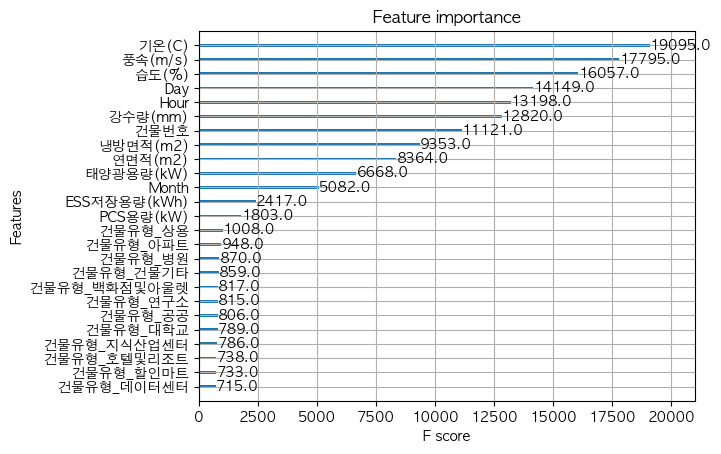

In [70]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False



plot_importance(bst)
plt.show();

In [71]:
bst.save_model(path + '0001.model') #save model
bst = xgb.Booster({'nthread': 4})  # init model
bst.load_model('model.bin')  # load data

In [65]:
pred = bst.predict(xgb.DMatrix(test_df))

array([1968.2177 , 1965.256  , 1342.6163 , ...,  427.66803,  453.76266,
        208.63881], dtype=float32)

In [66]:
sub['answer'] = pred

sub.to_csv(path + 'xgb_sub.csv')